# Shape descriptor analysis (Part 1)

We finally have some numbers to work with.
- **Traditional shape descriptors**: 11 numbers, like grain length, width, height, etc
- **Topological shape descriptors**: Variable number: from the Euler Characteristic Transform

How good are these descriptors? Can we characterize the shape of different founders based solely on their grain morphology? We can train a Support Vector Machine (SVM) with an 80/20 train/test breakdown and test the classification accuracy. The SVM can be trained with either
- Purely traditional descriptors
- Purely topological descriptors
- A combination of both descriptors

Take into account that the ECT produces extremely large vectors. To avoid pathological behavior, we must reduce their dimension as a first step.

In [1]:
suppressPackageStartupMessages(library(e1071))
suppressPackageStartupMessages(library(kernlab))

## Read and wrangle the data

- Read the CSV that contains both the traditional and topological descriptors
- For the topological descriptors, we select the file corresponding to the number of directions `d` and thresholds `TT`
- Get the name of founders and shorten some of their names (it will make plots less clustered later)
- Distinguish the columns referring to traditional or topological information

In [27]:
setwd('/home/ejam/documents/barley_stacks/preproc/norm_ect/results')
norm <- 'Normalized Size'
d <- 158
TT <- 8
founders <- read.csv(paste('combined_d',d,'_T',TT,'.csv',sep=''))

In [4]:
founders_names_original <- levels(unique(founders$Founder))
founders_names <- founders_names_original
founders_names[5] <- 'CA Mariout'
founders_names[11] <- 'Good Delta'
founders_names[17] <- 'Maison Carree'
founders_names[24] <- 'Palmella Blue'
founders_names[28] <- 'WI Winter'
print(founders_names)

 [1] "Algerian"        "Alpha"           "Arequipa"        "Atlas"          
 [5] "CA Mariout"      "Club Mariout"    "Everest"         "Flynn"          
 [9] "Glabron"         "Golden Pheasant" "Good Delta"      "Han River"      
[13] "Hannchen"        "Horn"            "Lion"            "Lyallpur"       
[17] "Maison Carree"   "Manchuria"       "Meloy"           "Minia"          
[21] "Multan"          "Oderbrucker"     "Orel"            "Palmella Blue"  
[25] "Sandrel"         "Trebi"           "White Smyrna"    "WI Winter"      


In [28]:
dim(founders)

trad_traits <- colnames(founders)[10:20]
print(trad_traits)
topo_traits <- colnames(founders)[21:ncol(founders)]
print(topo_traits[1:10])

[1] 3121 1284

 [1] "Length"          "Width"           "Height"          "HeightMax"      
 [5] "Shell"           "Area"            "Vol"             "ConvexArea"     
 [9] "ConvexVol"       "ConvexAreaRatio" "ConvexVolRatio" 
 [1] "X7"  "X15" "X23" "X31" "X39" "X47" "X55" "X63" "X71" "X79"


## Dimension reduction

- The ECT produces very high dimensional vectors. When considering 74 directions and 64 thresholds each, we obtain a $74\times64=4736$-dimensional vector for _each_ seed.
- Dimension reduction is performed with kernel PCA, using a Laplacian kernel

In [29]:
dims <- 12
kernel <- 'laplacedot'
kpar <- list(sigma=1)
kpc <- kernlab::kpca(~.,data=founders[,topo_traits], kernel=kernel, features=dims, kpar=kpar)

## Combine the descriptors

- Create a matrix with 23 descriptors per seed: 11 traditional and 12 topological
- Center and scale the descriptors so we don't have to repeat this step whenever computing SVMs

In [43]:
info_type <- 'Combined'
mixed <- cbind(founders[,trad_traits], kpc@rotated)
scaled_data <- base::scale(mixed, center=TRUE, scale=TRUE)
dim(scaled_data)
scaled_data[1:5, ]

[1] 3121   23

,Length,Width,Height,HeightMax,Shell,Area,Vol,ConvexArea,ConvexVol,ConvexAreaRatio,⋯,3,4,5,6,7,8,9,10,11,12
1,0.33277264,2.0880757,1.3426304,1.5325907,1.25191221,1.0868236,1.3225306,1.16746191,1.3774174,-0.5391536,⋯,-1.104082e-16,-7.602872e-18,3.635430e-17,1.389261e-17,-5.599158e-17,1.751885e-17,-3.160703e-17,-2.095990e-17,1.483759e-17,1.216598e-17
2,-0.11654863,-0.3338037,0.5324128,0.5326279,-0.06973813,0.1377740,0.1152911,0.07223388,0.1178263,0.7196770,⋯,1.195920e-02,-2.347649e-02,1.359711e-02,-6.626404e-03,1.349544e-03,5.044467e-02,9.555320e-03,2.814836e-03,-1.134730e-02,-1.324472e-02
3,-0.55052796,0.4842395,0.7308134,1.2625320,-0.03514948,-0.1004895,0.1157133,-0.02297631,0.1316591,-0.8063126,⋯,4.052952e-03,-5.354103e-03,5.251799e-02,2.202566e-03,1.056209e-02,-1.742858e-02,1.616178e-03,2.939675e-03,3.601633e-03,-2.677796e-03
4,0.04206057,0.6770330,1.3325318,1.4306697,0.74400526,0.4371050,0.7837276,0.62186402,0.7962748,-1.6617855,⋯,-4.079413e-03,2.652040e-02,3.802434e-02,-7.470408e-03,-1.141892e-02,-8.663931e-02,1.903914e-02,1.561918e-02,-2.336464e-03,-3.408520e-03
5,0.23999612,1.9765720,1.6997866,2.0690106,1.06895648,1.1699155,1.3054713,1.09432589,1.3407883,0.8421753,⋯,3.211307e-02,-1.248039e-02,3.113082e-02,-3.945422e-02,-5.911792e-02,5.651528e-02,-2.331383e-02,6.817680e-02,5.111699e-02,-1.086770e-02


## Classify with an SVM

- Do a 80/20 split for training/testing
- That is, select randomly 80% of the sample for each of the 28 grain varieties
- The rest will be used later to test to make sure we're not overfitting the training.

In [56]:
percent_train <- 0.8
train_ids <- c()
for(i in 1:length(founders_names_original)){
    seed_ids <- which(founders$Founder == founders_names_original[i])
    seed_train <- sample(seed_ids, size = floor(length(seed_ids)*percent_train), 
                         replace=FALSE)
    train_ids <- c(train_ids, seed_train)
}
test_ids <- setdiff(1:nrow(founders), train_ids)
train_labs <- founders$Founder[train_ids]
test_labs <- founders$Founder[test_ids]

- SVM can be sensitive to small parameter changes. 
- The best combination of parameters was based on a purely empirical approach

In [57]:
model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                    kernel='polynomial', coef0=25, degree=2, gamma=0.1, cost=200, scale=FALSE)
pred <- stats::predict(model, scaled_data[test_ids,])
clasification <- matrix(as.numeric(table(pred, test_labs)),
                        length(founders_names), length(founders_names))
accuracy <- sum(diag(clasification))/sum(clasification)

print(paste('Classification accuracy:', 100*signif(accuracy,3), '%'))

[1] "Classification accuracy: 71.5 %"


In [58]:
model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                    kernel='polynomial', coef0=5, degree=3, gamma=0.01, cost=150, scale=FALSE)
pred <- stats::predict(model, scaled_data[test_ids,])
clasification <- matrix(as.numeric(table(pred, test_labs)),
                        length(founders_names), length(founders_names))
accuracy <- sum(diag(clasification))/sum(clasification)

print(paste('Classification accuracy:', 100*signif(accuracy,3), '%'))

[1] "Classification accuracy: 71.5 %"


In [34]:
model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                    kernel='radial', gamma=0.01, cost=100, scale=FALSE)
pred <- stats::predict(model, scaled_data[test_ids,])
clasification <- matrix(as.numeric(table(pred, test_labs)),
                        length(founders_names), length(founders_names))
accuracy <- sum(diag(clasification))/sum(clasification)

print(paste('Classification accuracy:', 100*signif(accuracy,3), '%'))

[1] "Classification accuracy: 19.4 %"


- Once we're satisfied with our SVM parameter choice, run 100 different SVMs
- That is, select randomly 80% of the sample and test the rest
- Repeat this procedure 100 times
- We produce a $28\times28\times100$ array with all the results

In [30]:
info_type <- 'Combined'
mixed <- cbind(founders[,trad_traits], kpc@rotated)
scaled_data <- base::scale(mixed, center=TRUE, scale=TRUE)

sample_runs <- 100
percent_train <- 0.8
results <- base::array(0, dim=c(length(founders_names), length(founders_names), sample_runs))

for(j in 1:sample_runs){
    train_ids <- c()
    for(i in 1:length(founders_names_original)){
        seed_ids <- which(founders$Founder == founders_names_original[i])
        seed_train <- sample(seed_ids, size = floor(length(seed_ids)*percent_train), 
                             replace=FALSE)
        train_ids <- c(train_ids, seed_train)
    }
    test_ids <- setdiff(1:nrow(founders), train_ids)
    train_labs <- founders$Founder[train_ids]
    test_labs <- founders$Founder[test_ids]

    model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                        kernel='polynomial', coef0=5, degree=3, gamma=0.01, cost=50, scale=FALSE)
    pred <- stats::predict(model, scaled_data[test_ids,])
    results[,,j] <- matrix(as.numeric(table(pred, test_labs)),
                            length(founders_names), length(founders_names))
}

- Save the resulting 3D array as an RDS file

In [31]:
filename <- paste('svm_results',tolower(gsub(' ', '_', norm)), 
                  tolower(info_type), d, TT, kernel, dims, 'founders.rds', sep='_')
base::saveRDS(results, filename)

## Only Topological + KPCA information

- Now use only the topological descriptors

In [73]:
info_type <- 'Topological'
scaled_data <- base::scale(kpc@rotated, center=TRUE, scale=TRUE)
dim(scaled_data)

[1] 3121   12

In [ ]:
percent_train <- 0.8
train_ids <- c()
for(i in 1:length(founders_names_original)){
    seed_ids <- which(founders$Founder == founders_names_original[i])
    seed_train <- sample(seed_ids, size = floor(length(seed_ids)*percent_train), 
                         replace=FALSE)
    train_ids <- c(train_ids, seed_train)
}
test_ids <- setdiff(1:nrow(founders), train_ids)
train_labs <- founders$Founder[train_ids]
test_labs <- founders$Founder[test_ids]

In [35]:
model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                    kernel='polynomial', coef0=10, degree=2, gamma=5, cost=100, scale=FALSE)
pred <- stats::predict(model, scaled_data[test_ids,])
clasification <- matrix(as.numeric(table(pred, test_labs)),
                        length(founders_names), length(founders_names))
accuracy <- sum(diag(clasification))/sum(clasification)

print(paste('Classification accuracy:', 100*signif(accuracy,3), '%'))

[1] "Classification accuracy: 54.7 %"


In [41]:
model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                    kernel='radial', coef0=10, degree=2, gamma=5, cost=100, scale=FALSE)
pred <- stats::predict(model, scaled_data[test_ids,])
clasification <- matrix(as.numeric(table(pred, test_labs)),
                        length(founders_names), length(founders_names))
accuracy <- sum(diag(clasification))/sum(clasification)

print(paste('Classification accuracy:', 100*signif(accuracy,3), '%'))

[1] "Classification accuracy: 44.8 %"


In [32]:
info_type <- 'Topological'
scaled_data <- base::scale(kpc@rotated, center=TRUE, scale=TRUE)

sample_runs <- 100
percent_train <- 0.8
results <- base::array(0, dim=c(length(founders_names), length(founders_names), sample_runs))

for(j in 1:sample_runs){
    train_ids <- c()
    for(i in 1:length(founders_names_original)){
        seed_ids <- which(founders$Founder == founders_names_original[i])
        seed_train <- sample(seed_ids, size = floor(length(seed_ids)*percent_train), 
                             replace=FALSE)
        train_ids <- c(train_ids, seed_train)
    }
    test_ids <- setdiff(1:nrow(founders), train_ids)
    train_labs <- founders$Founder[train_ids]
    test_labs <- founders$Founder[test_ids]

    model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                        kernel='polynomial', coef0=10, degree=2, gamma=5, cost=100, scale=FALSE)
    pred <- stats::predict(model, scaled_data[test_ids,])
    results[,,j] <- matrix(as.numeric(table(pred, test_labs)),
                            length(founders_names), length(founders_names))
}

In [33]:
filename <- paste('svm_results',tolower(gsub(' ', '_', norm)), 
                  tolower(info_type), d, TT, kernel, dims, 'founders.rds', sep='_')
base::saveRDS(results, filename)

In [60]:
info_type <- 'Combined'
mixed <- cbind(founders[,trad_traits], kpc@rotated)
scaled_data <- base::scale(mixed, center=TRUE, scale=TRUE)
dim(scaled_data)
scaled_data[1:5, ]

filename <- paste('kpca',tolower(gsub(' ', '_', norm)), 
                  tolower(info_type), d, TT, kernel, dims, 'founders.csv', sep='_')

utils::write.csv(scaled_data, filename, row.names=FALSE, col.names=TRUE)

[1] 3121   23

,Length,Width,Height,HeightMax,Shell,Area,Vol,ConvexArea,ConvexVol,ConvexAreaRatio,⋯,3,4,5,6,7,8,9,10,11,12
1,0.33277264,2.0880757,1.3426304,1.5325907,1.25191221,1.0868236,1.3225306,1.16746191,1.3774174,-0.5391536,⋯,-1.104082e-16,-7.602872e-18,3.635430e-17,1.389261e-17,-5.599158e-17,1.751885e-17,-3.160703e-17,-2.095990e-17,1.483759e-17,1.216598e-17
2,-0.11654863,-0.3338037,0.5324128,0.5326279,-0.06973813,0.1377740,0.1152911,0.07223388,0.1178263,0.7196770,⋯,1.195920e-02,-2.347649e-02,1.359711e-02,-6.626404e-03,1.349544e-03,5.044467e-02,9.555320e-03,2.814836e-03,-1.134730e-02,-1.324472e-02
3,-0.55052796,0.4842395,0.7308134,1.2625320,-0.03514948,-0.1004895,0.1157133,-0.02297631,0.1316591,-0.8063126,⋯,4.052952e-03,-5.354103e-03,5.251799e-02,2.202566e-03,1.056209e-02,-1.742858e-02,1.616178e-03,2.939675e-03,3.601633e-03,-2.677796e-03
4,0.04206057,0.6770330,1.3325318,1.4306697,0.74400526,0.4371050,0.7837276,0.62186402,0.7962748,-1.6617855,⋯,-4.079413e-03,2.652040e-02,3.802434e-02,-7.470408e-03,-1.141892e-02,-8.663931e-02,1.903914e-02,1.561918e-02,-2.336464e-03,-3.408520e-03
5,0.23999612,1.9765720,1.6997866,2.0690106,1.06895648,1.1699155,1.3054713,1.09432589,1.3407883,0.8421753,⋯,3.211307e-02,-1.248039e-02,3.113082e-02,-3.945422e-02,-5.911792e-02,5.651528e-02,-2.331383e-02,6.817680e-02,5.111699e-02,-1.086770e-02


Warning message in write.csv(scaled_data, filename, row.names = FALSE, col.names = TRUE):
“attempt to set 'col.names' ignored”


In [72]:
pca <- stats::prcomp(t(founders[,trad_traits]), scale=TRUE)

In [76]:
pca$sdev

[1] 5.585257e+01 1.141398e+00 3.977231e-01 1.687642e-01 3.415884e-02
 [6] 3.450729e-03 1.518490e-03 1.156969e-03 6.172435e-04 1.489820e-05
[11] 3.753095e-14

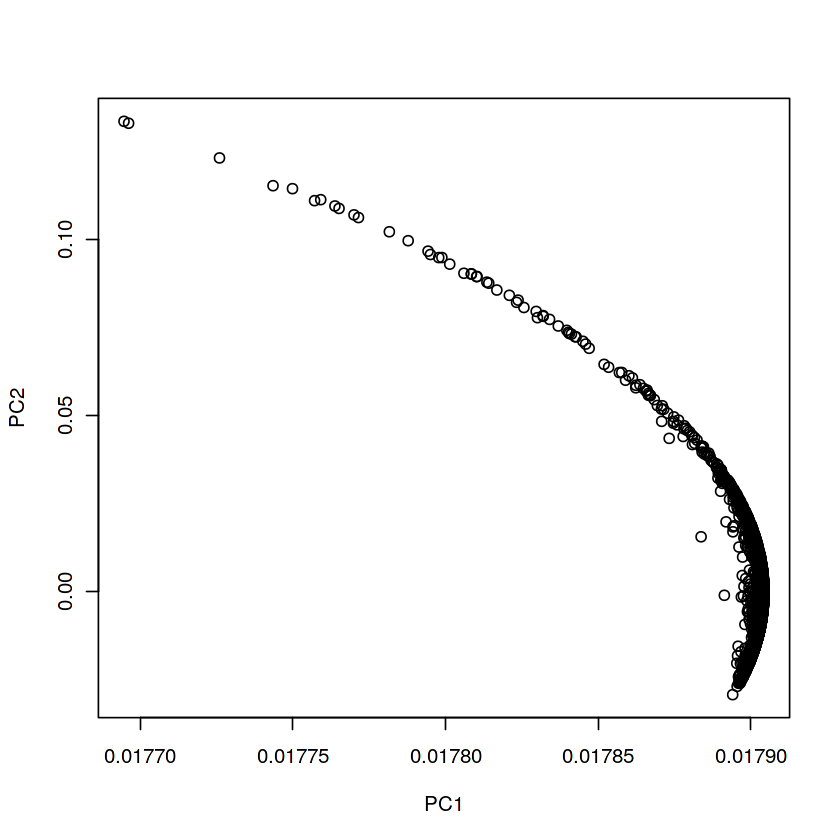

In [73]:
plot(pca$rotation[,1:3])

## Using only traditional measures

- Repeat the same procedure as before, except this time we use only the traditional descriptors
- **We are not affected by the KPCA step, and these results are independent of the parameters selected for the ECT**

In [85]:
info_type <- 'Traditional'
scaled_data <- base::scale(founders[,trad_traits], center=TRUE, scale=TRUE)
dim(scaled_data)

[1] 3121   11

In [93]:
info_type <- 'Traditional'
scaled_data <- base::scale(pca$rotation[,1:9], center=TRUE, scale=TRUE)
dim(scaled_data)

[1] 3121    9

In [103]:
mixed <- cbind(pca$rotation[,1:3], kpc@rotated)
scaled_data <- base::scale(mixed, center=TRUE, scale=TRUE)

In [104]:
percent_train <- 0.8
train_ids <- c()
for(i in 1:length(founders_names_original)){
    seed_ids <- which(founders$Founder == founders_names_original[i])
    seed_train <- sample(seed_ids, size = floor(length(seed_ids)*percent_train), 
                         replace=FALSE)
    train_ids <- c(train_ids, seed_train)
}
test_ids <- setdiff(1:nrow(founders), train_ids)
train_labs <- founders$Founder[train_ids]
test_labs <- founders$Founder[test_ids]

In [105]:
model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                    kernel='polynomial', coef0=5, degree=3, gamma=0.01, cost=50, scale=FALSE)
pred <- stats::predict(model, scaled_data[test_ids,])
clasification <- matrix(as.numeric(table(pred, test_labs)),
                        length(founders_names), length(founders_names))
accuracy <- sum(diag(clasification))/sum(clasification)

print(paste('Classification accuracy:', 100*signif(accuracy,3), '%'))

[1] "Classification accuracy: 41.8 %"


In [106]:
model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                    kernel='radial', coef0=10, degree=2, gamma=0.1, cost=10, scale=FALSE)
pred <- stats::predict(model, scaled_data[test_ids,])
clasification <- matrix(as.numeric(table(pred, test_labs)),
                        length(founders_names), length(founders_names))
accuracy <- sum(diag(clasification))/sum(clasification)

print(paste('Classification accuracy:', 100*signif(accuracy,3), '%'))

[1] "Classification accuracy: 38.8 %"


In [102]:
model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                    kernel='linear', coef0=10, degree=2, gamma=0.1, cost=10, scale=FALSE)
pred <- stats::predict(model, scaled_data[test_ids,])
clasification <- matrix(as.numeric(table(pred, test_labs)),
                        length(founders_names), length(founders_names))
accuracy <- sum(diag(clasification))/sum(clasification)

print(paste('Classification accuracy:', 100*signif(accuracy,3), '%'))

[1] "Classification accuracy: 64.8 %"


In [210]:
sample_runs <- 100
percent_train <- 0.8
results <- base::array(0, dim=c(length(founders_names), length(founders_names), sample_runs))

for(j in 1:sample_runs){
    train_ids <- c()
    for(i in 1:length(founders_names_original)){
        seed_ids <- which(founders$Founder == founders_names_original[i])
        seed_train <- sample(seed_ids, size = floor(length(seed_ids)*percent_train), 
                             replace=FALSE)
        train_ids <- c(train_ids, seed_train)
    }
    test_ids <- setdiff(1:nrow(founders), train_ids)
    train_labs <- founders$Founder[train_ids]
    test_labs <- founders$Founder[test_ids]

    model <- e1071::svm(scaled_data[train_ids,], train_labs, type='C-classification',
                        kernel='polynomial', coef0=10, degree=2, gamma=0.1, cost=10, scale=FALSE)
    pred <- stats::predict(model, scaled_data[test_ids,])
    results[,,j] <- matrix(as.numeric(table(pred, test_labs)),
                            length(founders_names), length(founders_names))
}

In [212]:
filename <- paste('svm_results',tolower(gsub(' ', '_', norm)), 
                  tolower(info_type), d, TT, kernel, dims, 'founders.rds', sep='_')
base::saveRDS(results, filename)